In [1]:

import numpy as np
import codecs
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nltk import Tree
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict
from scipy.sparse.csgraph import minimum_spanning_tree
import string

%matplotlib inline

Load data, validation (lines from 449)

In [2]:
attention_file = '../data/experiments/enSdeS-16h-bpeEDF100k/attentions.npz'
token_file = '../data/experiments/enSdeS-16h-bpeEDF100k/source.txt'

max_len = 1000

fontsize=8

layer=-1
head=-1
sentences=[4,5,6]
maxlen=1000

#this is necessary in this case
eos =True

In [3]:
attentions_loaded = np.load(attention_file)
sentences_count = len(attentions_loaded.files)
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

In [4]:
sentences_count

1000

Loaded attention processing

In [145]:
attentions_loaded['arr_6'].shape[2]

8

In [5]:
with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]

# recursively aggregated -- attention over input tokens
def wm_aggreg(this_layer, last_layer):
    return (np.matmul(this_layer, last_layer) + last_layer) / 2

# this layer and residual connection -- attention over positions
def wm_avg(this_layer, first_layer):
    return (this_layer + first_layer) / 2

def plot_matrix(matrix):

    fig, ax1 = plt.subplots(figsize=(9,9), ncols=1)
    im = ax1.imshow(matrix,cmap='Blues')
    fig.colorbar(im)
    plt.show()

total_count_phrases = 0
total_count_good = 0
total_sum_scores = 0
total_count_sentences = 0

colmaxes_all = dict()

Sentence preprocessing (joining subwords, checking rules)

In [74]:
sentence_index = 4

sentence_id = 'arr_' + str(sentence_index)
tokens_count = attentions_loaded[sentence_id].shape[2]
tokens_list = tokens_loaded[sentence_index]

# check maxlen
words = ' '.join(tokens_list).replace('@@ ', '')

if eos and tokens_list[-1] != 'EOS':
    tokens_list.append('EOS')

words_list = words.split()
if len(words_list) <= maxlen:
    print('Processing sentence', sentence_index, file=sys.stderr)


# NOTE sentences truncated to 64 tokens
# assert len(tokens_list) == tokens_count, "Bad no of tokens in sent " + str(sentence_index)
assert len(tokens_list) >= tokens_count, "Bad no of tokens in sent " + str(sentence_index)
if len(tokens_list) > tokens_count:
    TRUNCATED = True
    print('Truncating tokens from ', len(tokens_list), 'to', tokens_count,
            'on line', sentence_index, '(0-based indexing)', file=sys.stderr)
    tokens_list = tokens_list[:tokens_count]
else:
    TRUNCATED = False


Processing sentence 4


Creating visualization for the sentence

In [75]:
word_mixture = list() 
word_mixture.append(np.identity(tokens_count))
# for visualisation -- vis[layer][aggreg][head]
vis = list()

for layer in range(layers_count):
    layer_deps = list()  # for vis
    layer_matrix = np.zeros((tokens_count, tokens_count))
    for head in range(heads_count):
        matrix = attentions_loaded[sentence_id][layer][head]
        # the max trick -- for each row subtract its max
        # from all of its components to get the values into (-inf, 0]            
        matrix = np.transpose(np.transpose(matrix) - np.max(matrix, axis=1))
        # softmax
        exp_matrix = np.exp(matrix)
        deps = np.transpose(np.transpose(exp_matrix) / np.sum(exp_matrix, axis=1))
        layer_deps.append(deps)
        layer_matrix = layer_matrix + deps
    # avg
    layer_matrix = layer_matrix / heads_count
    layer_deps.append(layer_matrix)
    
    # next layer = avg of this layer and prev layer
    # TODO add head weights from ff matrices
    vis.append([
            layer_deps,
            [wm_aggreg(m, word_mixture[layer]) for m in layer_deps],
            ])
    word_mixture.append( wm_aggreg(layer_matrix, word_mixture[layer]) )

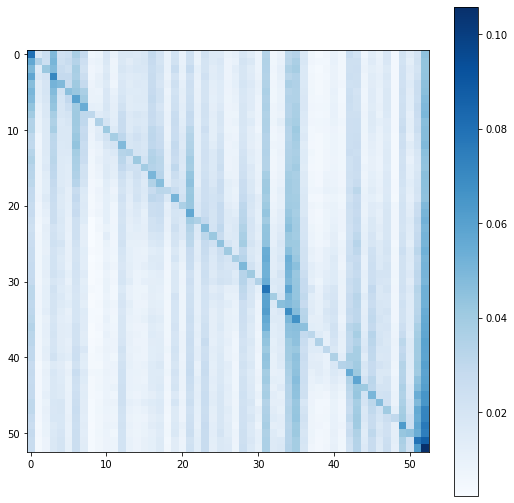

In [64]:
plot_matrix(word_mixture[6])

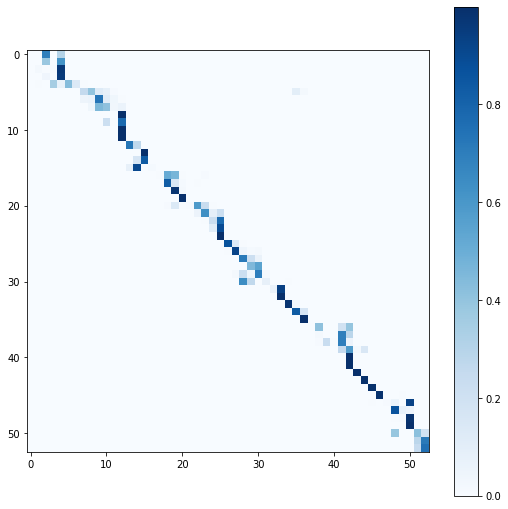

In [63]:
plot_matrix(vis[5][0][0])

In [81]:
def cky(phrase_weight, wordpieces):
    # CKY on wordpieces
    size = len(wordpieces)
    ctree = [[0 for i in range(size)] for j in range(size)]
    score = np.zeros((size, size))
    for i in range(size):

        score[i][i] = 0.5
    for span in range(1, size):
        for pos in range(0, size):
            if (pos + span < size):
                best_score = -1
                best_variant = 0
                for variant in range(1, span + 1):
                    var_score = (  phrase_weight[pos][pos + span - variant] \
                                 + score[pos][pos + span - variant] \
                                 + phrase_weight[pos + span - variant + 1][pos + span] \
                                 + score[pos + span - variant + 1][pos + span] \
                                ) / 4 
                    if (best_score < var_score):
                        best_score = var_score
                        best_variant = variant
                score[pos][pos + span] = best_score
                ctree[pos][pos + span] = Tree('X', [ctree[pos][pos + span - best_variant], ctree[pos + span - best_variant + 1][pos + span]])
    return ctree[0][size - 1]


def phrasetree(vis, wordpieces, layer, aggreg, head, sentence_index):
    size = len(wordpieces)
    layer_list = range(len(vis))
    if layer != -1:
        layer_list = [layer]
    head_list = range(len(vis[layer][0]))
    if head != -1:
        head_list = [head]
    phrase_weight = np.zeros((size, size))
    # iterate over all layers
    for l in layer_list:

        for h in head_list:
            # save a maximum value for each row, except the diagonal
            #max_in_row = np.max(vis[l][aggreg][h] - np.diagflat(np.ones(size)), axis=1) # ORIGINAL
            #vis[l][aggreg][h] -= 0.5 * np.diagflat(np.ones(size))                        # ALTERNATIVE
            max_in_row = np.max(vis[l][aggreg][h], axis=1)                               # ALTERNATIVE
            #print(np.round(vis[l][aggreg][h],1))
            #print(np.round(vis[l][aggreg][h] - np.diagflat(np.ones(size)),1))
            #print(np.round(max_in_row,1))
            for column in range(size):
                i = 0
                while i < size:
                    current_sum = 0
                    for j in range(i, size):
                        value = vis[l][aggreg][h][j][column]
                        if value < max_in_row[j]:
                        #if value < 0.2:
                        #if value < 0.1:
                            j -= 1
                            break
                        current_sum += value
                    if j >= i:
                        pw = current_sum / (j - i + 1)
                        #if (phrase_weight[i][j] < pw):
                        #    phrase_weight[i][j] = pw
                        phrase_weight[i][j] += pw
                    i = j + 2

    # normalize phrase_weight, so that the mean on each diagonal is 0.5
    for span in range(size):
        factor = 0
        count = 0
        for i in range(size - span):
            if (phrase_weight[i][i + span] > 0):
                factor += phrase_weight[i][i + span]
                count += 1
        if (count > 0):
            factor = factor / count * 2
            for i in range(size - span):
                if (factor != 0):
                    phrase_weight[i][i + span] /= factor

    #print(phrase_weight)
    #print(np.round(phrase_weight,1))
    # parse the tree recursively in top-down fashion
    #tree = parse_subtree(0, size - 1, phrase_weight, wordpieces)
    
    plot_matrix(phrase_weight)
    
    # parse tree using CKY
    tree = cky(phrase_weight, wordpieces)

    return(tree)

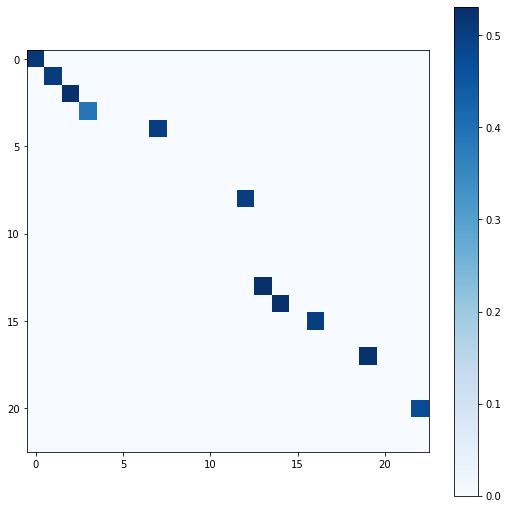

In [100]:
tree = phrasetree(vis, tokens_list, 2, 0, 5, 0)

In [84]:
from IPython.display import Image, display
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame

def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 13 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 10, 10)
    cf.print_to_file('tmp_tree_output.ps')
    cf.destroy()
    os.system('convert tmp_tree_output.ps tmp_tree_output.png')
    display(Image(filename='tmp_tree_output.png'))
    os.system('rm tmp_tree_output.ps tmp_tree_output.png')
    
jupyter_draw_nltk_tree(tree)

TclError: no display name and no $DISPLAY environment variable

In [63]:
layers_count

6

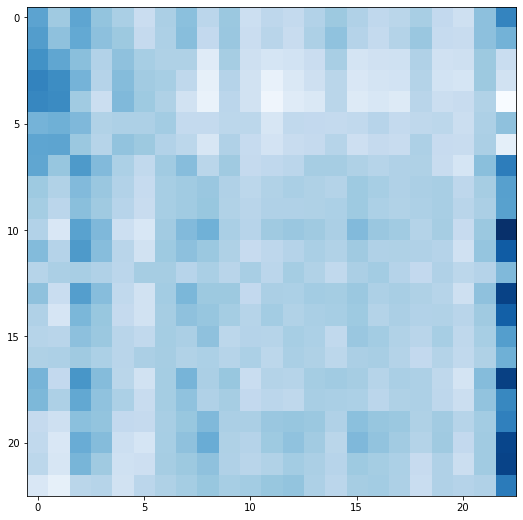

In [41]:
plot_matrix(matrix)



In [87]:
display(tree)


TclError: no display name and no $DISPLAY environment variable

Tree('X', [Tree('X', [Tree('X', [Tree('X', [Tree('X', [0, 0]), Tree('X', [Tree('X', [0, Tree('X', [0, 0])]), 0])]), Tree('X', [0, 0])]), Tree('X', [Tree('X', [Tree('X', [0, Tree('X', [0, 0])]), Tree('X', [0, 0])]), Tree('X', [Tree('X', [0, 0]), Tree('X', [0, Tree('X', [Tree('X', [0, 0]), Tree('X', [0, Tree('X', [0, 0])])])])])])]), Tree('X', [0, 0])])

In [82]:
np.shape(vis)

(6, 2, 17, 23, 23)

In [9]:
heads_count

16

In [14]:
np.shape(vis)

(6, 2, 17, 8, 8)